In [1]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from PIL import Image
import yaml
import random
from torchvision import transforms

# === Загрузка настроек ===
with open('parametrs.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

# === Установка сидов ===
seed = config['experiment']['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# === Устройство ===
device = torch.device(config['training']['device'] if torch.cuda.is_available() else "cpu")

# === Загрузка модели ViT ===
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=3)
checkpoint_path = "checkpoints/cosin/cosin_vit_fold1.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.to(device)
model.eval()

# === Датасет и загрузчик ===
class FundusDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, config):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.config = config

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['image_name']
        label = int(row['true_label'])
        img_path = os.path.join(self.root_dir, str(label), img_name)
        image = Image.open(img_path).convert("RGB")
        
        transform = get_transform_pipeline(self.config, label=label)
        image = transform(image)

        return image, label, img_name

def get_transform_pipeline(config, label=None):
    transform_list = []
    transform_list.append(transforms.Resize(config['dataset']['image_size']))
    transform_list.extend([transforms.ToTensor(), transforms.Normalize(mean=config['dataset']['mean'], std=config['dataset']['std'])])
    return transforms.Compose(transform_list)

# Загрузка данных
train_df = pd.read_csv('D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_all_image.csv')
root_dir = 'D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_old'

train_dataset = FundusDataset(train_df, root_dir=root_dir, config=config)
train_loader = DataLoader(train_dataset, batch_size=config['training']['batch_size'], shuffle=False)

# === Извлечение эмбеддингов ===
embeddings = []
labels = []
image_paths = []

with torch.no_grad():
    for images, batch_labels, paths in train_loader:
        images = images.to(device)
        outputs = model(pixel_values=images, output_hidden_states=True)
        batch_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        
        embeddings.extend(batch_embeddings)
        labels.extend(batch_labels.numpy())
        image_paths.extend(paths)

embeddings = np.array(embeddings)

d:\dataset\dataset_create\pythonProject\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# === Формируем DataFrame с эмбеддингами ===
df_embeddings = pd.DataFrame({
    'image_name': image_paths,
    'true_label': labels,
    'embedding': list(embeddings)
})

# === Делим по классам ===
df_0 = df_embeddings[df_embeddings['true_label'] == 0].copy()
df_1 = df_embeddings[df_embeddings['true_label'] == 1].copy()
df_2 = df_embeddings[df_embeddings['true_label'] == 2].copy()

# === Вычисление центров классов 1 и 2 ===
emb_1 = np.stack(df_1['embedding'].values)
emb_2 = np.stack(df_2['embedding'].values)
center_1 = emb_1.mean(axis=0)
center_2 = emb_2.mean(axis=0)

# === Расчёт расстояний от каждого emb из класса 0 до центров 1 и 2 ===
emb_0 = np.stack(df_0['embedding'].values)
dist_to_1 = cosine_distances(emb_0, center_1.reshape(1, -1)).flatten()
dist_to_2 = cosine_distances(emb_0, center_2.reshape(1, -1)).flatten()
min_dist = np.minimum(dist_to_1, dist_to_2)

df_0['dist_to_1_or_2'] = min_dist

# === Оставляем 6260 наиболее "пограничных" примеров класса 0 ===
df_0_selected = df_0.nsmallest(6260, 'dist_to_1_or_2')

# === Объединяем сбалансированный датасет ===
df_1_sampled = df_1.sample(n=6260, random_state=seed) if len(df_1) > 6260 else df_1
df_2_sampled = df_2.sample(n=6260, random_state=seed) if len(df_2) > 6260 else df_2

df_balanced = pd.concat([df_0_selected, df_1_sampled, df_2_sampled], ignore_index=True)

print(df_balanced['true_label'].value_counts())

true_label
0    6260
1    6260
2     499
Name: count, dtype: int64


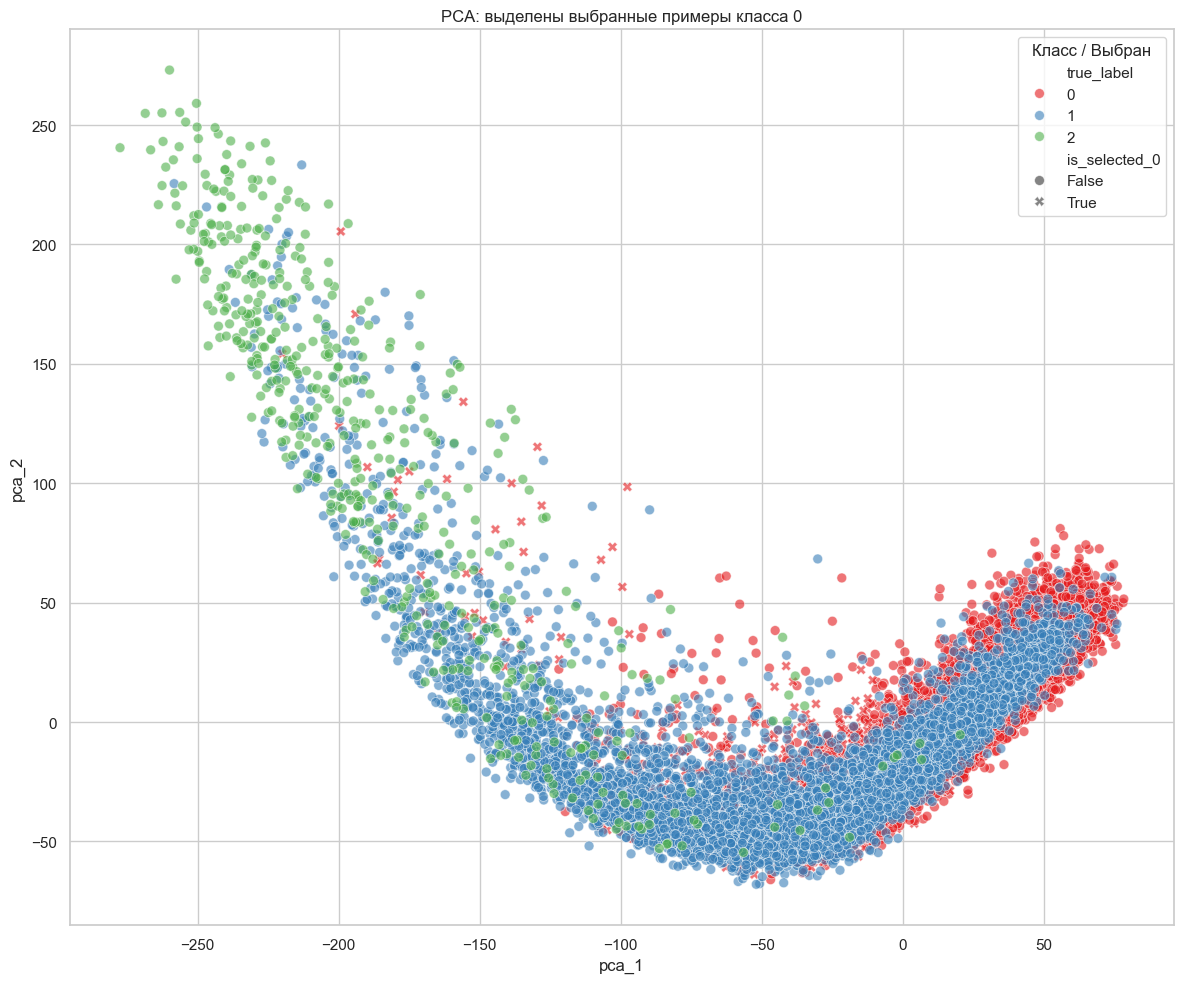

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Объединяем все эмбеддинги в один массив
df_embeddings['is_selected_0'] = False
df_embeddings.loc[df_0_selected.index, 'is_selected_0'] = True

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=seed)
X_pca = pca.fit_transform(np.stack(df_embeddings['embedding'].values))
df_embeddings[['pca_1', 'pca_2']] = X_pca

# Палитра и стиль
sns.set(style="whitegrid", rc={"figure.figsize": (10, 8)})

# Визуализация
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_embeddings, x="pca_1", y="pca_2", hue="true_label",
    style="is_selected_0", alpha=0.6, palette='Set1', s=50
)
plt.title("PCA: выделены выбранные примеры класса 0")
plt.legend(title="Класс / Выбран")
plt.tight_layout()
plt.show()


In [5]:
import shutil
from tqdm import tqdm

# === Куда копируем ===
target_dir = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/typical/train/0"
os.makedirs(target_dir, exist_ok=True)

# === Откуда копируем ===
source_dir = root_dir  # твой исходный root_dir, например "D:/dataset/_eyepacs/data/filtered_data_with_cosine/train_old"

# === Копирование файлов ===
for img_name in tqdm(df_0_selected['image_name']):
    src_path = os.path.join(source_dir, '0', img_name)
    dst_path = os.path.join(target_dir, img_name)
    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
    else:
        print(f"Не найден файл: {src_path}")


100%|██████████| 6260/6260 [00:14<00:00, 421.36it/s]


In [6]:
import os
import pandas as pd
from tqdm import tqdm

# Путь к новой папке
base_dir = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/typical/train"

# Список для записи информации
records = []

# Проходим по каждому классу (0, 1, 2)
for class_label in ['0', '1', '2']:
    class_dir = os.path.join(base_dir, class_label)
    if not os.path.exists(class_dir):
        print(f"Папка не найдена: {class_dir}")
        continue
    for img_name in tqdm(os.listdir(class_dir), desc=f"Класс {class_label}"):
        if img_name.endswith(('.png', '.jpg', '.jpeg')):  # Только картинки
            records.append({
                'image_name': img_name,
                'true_label': int(class_label)
            })

# Создание DataFrame
new_df = pd.DataFrame(records)

# Перемешать строки
new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Сохранение
save_path = "D:/dataset/_eyepacs/data/filtered_data_with_cosine/typical/train_typical.csv"
new_df.to_csv(save_path, index=False)

print(f"Новый датасет сохранён: {save_path}")
print(new_df['true_label'].value_counts())


Класс 2: 100%|██████████| 6260/6260 [00:00<00:00, 1038497.93it/s]

Новый датасет сохранён: D:/dataset/_eyepacs/data/filtered_data_with_cosine/typical/train_typical.csv
true_label
1    6260
2    6260
0    6260
Name: count, dtype: int64
